In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import torchvision.utils as vutils
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])
dataset =  datasets.ImageFolder(root='/kaggle/input/animals10/raw-img', transform=transform)
print(dataset.classes)
dataset

['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']


Dataset ImageFolder
    Number of datapoints: 26179
    Root location: /kaggle/input/animals10/raw-img
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

In [3]:
train_split = int(len(dataset) * 0.9)
test_split = len(dataset) - train_split
train_data, test_data = random_split(dataset, [train_split, test_split])
train_loader = DataLoader(train_data, batch_size = 32, shuffle=True)
test_loader = DataLoader(test_data, batch_size = 32, shuffle=True)

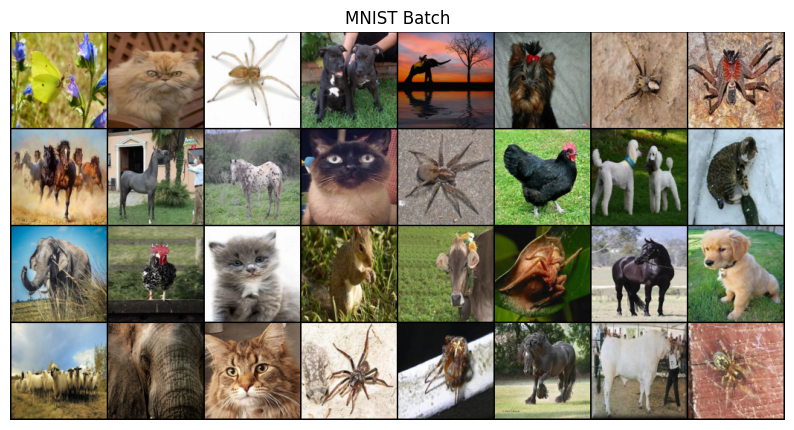

In [4]:
one = iter(train_loader)
images, labels = next(one)

grid = vutils.make_grid(images, nrow=8, padding=2)

np_grid = grid.permute(1, 2, 0).numpy()

plt.figure(figsize=(10, 10))
plt.imshow(np_grid)
plt.title('MNIST Batch')
plt.axis('off')
plt.show()

In [5]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size = 3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size = 3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size = 3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 128, kernel_size = 3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(128, 256, kernel_size = 3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.full1 = nn.Linear(16 * 16 * 256, 1280)
        self.full2 = nn.Linear(1280, 10)
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, kernel_size =2)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, kernel_size =2)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, kernel_size =2)
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.full1(x.view(-1, 16 * 16 * 256)))
        x = self.full2(x)

        return x
        

In [6]:
model = CNN()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [7]:
model.to(device)
loss_avg = 0
for epochs in range(5):
    d = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_avg += loss.item()
        if d % 100 == 0:
            print(loss_avg/100)
            loss_avg = 0
        d+= 1
            
        

0.02286787509918213
2.0411098229885103
1.5481531703472138
1.3775696867704392
1.2942757588624954
1.2765686756372452
1.1896026474237442
1.1341112077236175
0.42254857361316683
0.9407535243034363
0.9176050090789795
0.9219929707050324
0.9440225502848625
0.9158078199625015
0.9258983218669892
0.8823575481772423
0.33635801434516904
0.6887517741322517
0.6747807501256466
0.7136655950546265
0.653369534611702
0.6726937821507454
0.7075338998436927
0.6816754075884819
0.25423037678003313
0.4532435604929924
0.46554293885827064
0.4904864424467087
0.5248828829824924
0.4444707717001438
0.4985097090899944
0.4679950821399689
0.20214013367891312
0.31021653771400454
0.29259812749922276
0.28893346890807153
0.282897696942091
0.3101672188937664
0.30243172846734523
0.33223849192261695


In [8]:
model.eval()
correct = 0
total = 0
correct = 0
total = 0
with torch.no_grad():
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.shape[0]
        correct += (predicted == labels).sum().item()

print(f"Train Accuracy: {100 * correct / total}%")

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.shape[0]
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total}%")


Train Accuracy: 94.78375281185009%
Test Accuracy: 92.34118950303679%


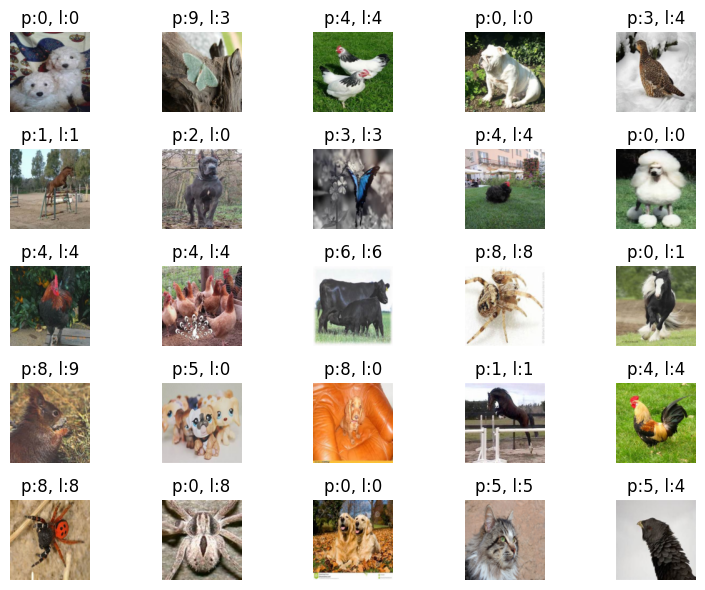

In [9]:
with torch.no_grad():
    one = iter(test_loader)
    images, labels = next(one)
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    dimension = 5
    fig, axes = plt.subplots(dimension, dimension, figsize=(8, 6))
    axes = axes.ravel()
    for i in range(dimension**2):
        axes[i].imshow(images[i].cpu().permute(1, 2, 0).numpy())  
        axes[i].set_title(f"p:{predicted[i]}, l:{labels[i]}")
        axes[i].axis('off')  
    
    plt.tight_layout()
    plt.show()
